In [1]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [2]:
isotope_list = StellarChem.get_isotope_list()

Dict{Symbol, Isotope} with 3352 entries:
  :Ne26  => Isotope(10, 26, "Ne", 26.0005)
  :C22   => Isotope(6, 22, "C", 22.0575)
  :Pr143 => Isotope(59, 143, "Pr", 142.911)
  :Re163 => Isotope(75, 163, "Re", 162.972)
  :Cu52  => Isotope(29, 52, "Cu", 51.9967)
  :Co50  => Isotope(27, 50, "Co", 49.9809)
  :Sr74  => Isotope(38, 74, "Sr", 73.9562)
  :Pt188 => Isotope(78, 188, "Pt", 187.959)
  :No258 => Isotope(102, 258, "No", 258.098)
  :Pb210 => Isotope(82, 210, "Pb", 209.984)
  :Dy148 => Isotope(66, 148, "Dy", 147.927)
  :Hg200 => Isotope(80, 200, "Hg", 199.968)
  :Ir182 => Isotope(77, 182, "Ir", 181.958)
  :Md246 => Isotope(101, 246, "Md", 246.082)
  :Lr251 => Isotope(103, 251, "Lr", 251.094)
  :Cu75  => Isotope(29, 75, "Cu", 74.9415)
  :Ce144 => Isotope(58, 144, "Ce", 143.914)
  :Xe125 => Isotope(54, 125, "Xe", 124.906)
  :Ni66  => Isotope(28, 66, "Ni", 65.9291)
  ⋮      => ⋮

In [14]:
function equationHSE(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                            κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnP₀ = var00[sm.vari[:lnP]]
        r₀ = exp(var00[sm.vari[:lnr]])
        g₀ = CGRAV*sm.mstar/r₀^2
        return lnP₀ -log(2g₀/(3κ00)) # Eddington gray, ignoring radiation pressure term
    end
    lnP₊ = varp1[sm.vari[:lnP]]
    lnP₀ = var00[sm.vari[:lnP]]
    lnPface = (sm.dm[k]*lnP₀ + sm.dm[k+1]*lnP₊)/(sm.dm[k]+sm.dm[k+1])
    r₀ = exp(var00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k])
    
    return (exp(lnPface)*(lnP₊ - lnP₀)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.m[k]/(4π*r₀^4))
end

function equationT(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnT₀ = var00[sm.vari[:lnT]]
        L₀ = var00[sm.vari[:lum]]*LSUN
        r₀ = exp(var00[sm.vari[:lnr]])
        return lnT₀ - log(L₀/(BOLTZ_SIGMA*4π*r₀^2))/4 # Eddington gray, ignoring radiation pressure term
    end
    κface = exp((sm.dm[k]*log(κ00) + sm.dm[k+1]*log(κp1))/(sm.dm[k]+sm.dm[k+1]))
    L₀ = var00[sm.vari[:lum]]*LSUN
    r₀ = exp(var00[sm.vari[:lnr]])
    Pface = exp((sm.dm[k]*var00[sm.vari[:lnP]] + sm.dm[k+1]*varp1[sm.vari[:lnP]])/(sm.dm[k]+sm.dm[k+1]))
    lnT₊ = varp1[sm.vari[:lnT]]
    lnT₀ = var00[sm.vari[:lnT]]
    Tface = exp((sm.dm[k]*lnT₀ + sm.dm[k+1]*lnT₊)/(sm.dm[k]+sm.dm[k+1]))

    ∇ᵣ = 3κface*L₀*Pface/(16π*CRAD*CLIGHT*CGRAV*sm.m[k]*Tface^4)
    ∇ₐ = (sm.dm[k]*eos00[7] + sm.dm[k+1]*eosp1[7])/(sm.dm[k]+sm.dm[k+1])

    if (∇ᵣ < ∇ₐ)
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ᵣ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    else
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ₐ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    end
end

function equationLuminosity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    L₋::TT = 0 # central luminosity is zero at first cell
    if k>1
        L₋ = varm1[sm.vari[:lum]]*LSUN # change it if not at first cell
    end
    L₀ = var00[sm.vari[:lum]]*LSUN
    ρ₀ = eos00[1]
    cₚ = eos00[5]
    δ = eos00[6]
    dTdt = (exp(var00[sm.vari[:lnT]]) - exp(sm.ssi.lnT[k]))/sm.ssi.dt
    dPdt = (exp(var00[sm.vari[:lnP]]) - exp(sm.ssi.lnP[k]))/sm.ssi.dt

    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18

    return ((L₀-L₋)/sm.dm[k]-ϵnuc+cₚ*dTdt -(δ/ρ₀)*dPdt) # no nuclear reactions or neutrinos
end

function equationContinuity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                   eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                   κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    r₀ = exp(var00[sm.vari[:lnr]])
    r₋::TT = 0 # central radius is zero at first cell
    if k>1
        r₋ = exp(varm1[sm.vari[:lnr]]) # change it if not at first cell
    end
    
    dm = sm.m[k] # this is only valid for k=1
    if k>1
        dm = dm-sm.m[k-1]
    end

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ₀)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    return (expected_dr³_dm - actual_dr³_dm)*ρ₀
end

#  To test performance, include 8 isotopes similar to basic.net in MESA.
#  of course we are keeping these fixed now, but it lets us test their impact on the
#  computation of the jacobian

function equationH1(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18
    rate_per_unit_mass = 4*ϵnuc/((4*isotope_list[:H1].mass-isotope_list[:He4].mass)*AMU*CLIGHT^2)

    Xi = sm.ssi.ind_vars[(k-1)*sm.nvars+sm.vari[:H1]]

    return (var00[sm.vari[:H1]]-Xi)/sm.ssi.dt + isotope_list[:H1].mass*AMU*rate_per_unit_mass
end

function equationHe4(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return  var00[sm.vari[:He4]] + var00[sm.vari[:H1]] - 1.0
end

equationHe4 (generic function with 1 method)

In [15]:
nvars = 6
nspecies = 2
varnames = [:lnP,:lnT,:lnr,:lum,:H1, :He4]
structure_equations=[equationHSE, equationT,
                        equationContinuity, equationLuminosity,
                        equationH1, equationHe4]
nz = 1000
eos = StellarEOS.IdealEOS(false)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [16]:
# use an n=1 polytrope as initial condition, should be better than a constant density star
using ForwardDiff
using Roots

isotope_list = StellarChem.get_isotope_list()

function theta_n(xi)
    return sin(xi)/xi
end

M = MSUN
R = 100*RSUN
n=1

# create a profile for composition that better resolves edges
function get_logdq(k, nz, logdq_low, logdq_high, numregion)
    if k<numregion
        return logdq_low+(k-1)*(logdq_high - logdq_low)/(numregion-1)
    elseif k<nz-numregion
        return logdq_high
    else
        k0 = nz-numregion
        k1 = nz
        return logdq_high+(logdq_low-logdq_high)*(k-k0)/(k1-k0)
    end
end
logdqs = get_logdq.(1:sm.nz,sm.nz,-3.0,0.0,100)
dqs = 10 .^ logdqs
dqs = dqs./sum(dqs)
dms = dqs.*M
m_face = cumsum(dms)
m_cell = cumsum(dms)
#correct m_center
for i in 1:sm.nz
    if i==1
        m_cell[i] = 0
    elseif i!=sm.nz
        m_cell[i] = m_cell[i] - 0.5*dms[i]
    end
end

function n1_polytrope_initial_condition(sm::StellarModel, M::Real, R::Real)

    rn = R/π # ξ is defined as r/rn, where rn^2=(n+1)Pc/(4π G ρc^2)

    ρc = M/(4π*rn^3*(-π^2*ForwardDiff.derivative(theta_n, π)))
    Pc = 4π*CGRAV*rn^2*ρc^2/(n+1)

    @show ρc, Pc

    ξ_cell = zeros(sm.nz)
    ξ_face = zeros(sm.nz)
    function mfunc(ξ,m)
        return m - 4π*rn^3*ρc*(-(-sin(ξ)+cos(ξ)*ξ))
    end

    for i in 1:sm.nz
        if i==1
            ξ_cell[i] = 0
        elseif i==sm.nz
            ξ_cell[i] = π
        else
            mfunc_anon = ξ->mfunc(ξ,m_cell[i])
            ξ_cell[i] = find_zero(mfunc_anon, (0,π), Bisection())
        end
        if i==sm.nz
            ξ_face[i] = π
        else
            mfunc_anon = ξ->mfunc(ξ,m_face[i])
            ξ_face[i] = find_zero(mfunc_anon, (0,π), Bisection())
        end
    end

    #set radii, pressure and temperature, assuming ideal gas without Prad
    for i in 1:sm.nz
        μ = 0.5
        XH = 1.0
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(rn*ξ_face[i])
        if i>1
            P = Pc*(theta_n(ξ_cell[i]))^(n+1)
            ρ = ρc*(theta_n(ξ_cell[i]))^(n)
        else
            P = Pc
            ρ = ρc
        end
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P)
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(P*μ/(CGAS*ρ)) 
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = 1.0
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He4]] = 0
    end

    #set m and dm
    sm.mstar = M
    sm.dm = dms
    sm.m = m_face

    #set luminosity 
    for i in 1:sm.nz-1
        μ = 0.5
        Pface = Pc*(theta_n(ξ_face[i]))^(n+1)
        ρface = ρc*(theta_n(ξ_face[i]))^(n)
        Tface = Pface*μ/(CGAS*ρface)
        dlnT = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnT]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
        dlnP = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnP]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
        κ=0.2
        sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]] = (dlnT/dlnP)*(16π*CRAD*CLIGHT*CGRAV*m_face[i]*Tface^4)/(3κ*Pface)/LSUN
    end

    #special cases, just copy values at edges
    sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnP]]
    sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnT]]
    sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lum]]

    sm.time = 0.0
    sm.dt = SECYEAR
    sm.model_number = 0
end

n1_polytrope_initial_condition (generic function with 1 method)

In [17]:
# set end step info (sm.esi) from current state
function set_end_step_info(sm::StellarModel)
    sm.esi.model_number = sm.model_number
    sm.esi.time = sm.time
    sm.esi.dt = sm.dt

    sm.esi.nz = sm.nz
    sm.esi.mstar = sm.mstar
    for i in 1:sm.nz
        sm.esi.m[i] = sm.m[i]
        sm.esi.dm[i] = sm.dm[i]

        sm.esi.lnT[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
        sm.esi.L[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]]
        sm.esi.lnP[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
        sm.esi.lnr[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]]

        species_names = sm.varnames[sm.nvars-sm.nspecies+1:end]
        xa = sm.ind_vars[i*sm.nvars-sm.nspecies+1:i*sm.nvars]

        eos = get_EOS_resultsTP(sm.eos, sm.isotope_data, sm.psi.lnT[i], sm.psi.lnP[i], xa,species_names)
        
        sm.esi.lnρ[i] = eos[1]
        sm.esi.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars] .= sm.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars]
    end
end

function cycle_step_info(sm::StellarModel)
    temp_step_info = sm.psi
    sm.psi = sm.esi
    sm.esi = sm.ssi
    sm.ssi = temp_step_info
end

function set_start_step_info(sm::StellarModel)
    # for now, we dont do anything special before the step (ie remeshing) so we just copy things from sm.psi
    sm.ssi.model_number = sm.psi.model_number
    sm.ssi.time = sm.psi.time
    sm.ssi.dt = sm.psi.dt

    sm.ssi.nz = sm.psi.nz
    sm.ssi.mstar = sm.mstar
    for i in 1:sm.nz
        sm.ssi.m[i] = sm.psi.m[i]
        sm.ssi.dm[i] = sm.psi.dm[i]

        sm.ssi.lnT[i] = sm.psi.lnT[i]
        sm.ssi.L[i] = sm.psi.L[i]
        sm.ssi.lnP[i] = sm.psi.lnP[i]
        sm.ssi.lnr[i] = sm.psi.lnr[i]
        sm.ssi.lnρ[i] = sm.psi.lnρ[i]
        sm.ssi.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars] .= sm.psi.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars]
    end
end

function get_dt_next(sm::StellarModel)
    dt_next = sm.esi.dt
    if (sm.esi.model_number==0)
        return dt_next
    else
        Rsurf = exp(sm.esi.lnr[sm.esi.nz])
        Rsurf_old = exp(sm.psi.lnr[sm.esi.nz])
        ΔR_div_R = abs(Rsurf-Rsurf_old)/Rsurf
        
        Tc = exp(sm.esi.lnT[sm.esi.nz])
        Tc_old = exp(sm.psi.lnT[sm.esi.nz])
        ΔTc_div_Tc = abs(Tc-Tc_old)/Tc

        X = sm.esi.ind_vars[(sm.esi.nz-1)*sm.nvars+sm.vari[:H1]]
        Xold = sm.psi.ind_vars[(sm.esi.nz-1)*sm.nvars+sm.vari[:H1]]
        ΔX = abs(X-Xold)/(X+0.001)

        dt_nextR = dt_next*sm.opt.timestep.delta_R_limit/ΔR_div_R
        dt_nextTc = dt_next*sm.opt.timestep.delta_Tc_limit/ΔTc_div_Tc
        dt_nextX = dt_next*sm.opt.timestep.delta_Xc_limit/ΔX

        dt_next = min(2*dt_next, dt_nextR, dt_nextTc, dt_nextX)
        return dt_next
    end
end

n1_polytrope_initial_condition(sm, MSUN, RSUN)

set_end_step_info(sm)
cycle_step_info(sm)
set_start_step_info(sm)

StellarEvolution.eval_jacobian!(sm)
StellarEvolution.eval_eqs!(sm)

(ρc, Pc) = (4.6342349991388145, 4.4201211223618375e15)


In [18]:
sm.linear_solver.A = sm.jac
sm.linear_solver.b = sm.eqs
corr =solve(sm.linear_solver)

u: 6000-element Vector{Float64}:
  -0.16405534414973602
   0.038411742764908295
   0.06995492205304592
  -4.874949109668821
   2.614062667420489e-9
  -2.614062667420489e-9
  -0.1641332984328892
   0.0383574668103451
   0.06995025903422028
 -10.100451405505893
   ⋮
  -0.0012885006238781641
  -4.5143857387829165e-24
   4.5143857387829165e-24
  10.685767681058017
   4.224064769811913
  -0.09182280974490348
   0.00015472267497623816
  -4.8364663148449776e-24
   4.8364663148449776e-24

In [27]:
using LinearSolve
@benchmark begin
    $sm.linear_solver.A = $sm.jac
    $sm.linear_solver.b = $sm.eqs
    corr =solve($sm.linear_solver)
end

BenchmarkTools.Trial: 989 samples with 1 evaluation.
 Range (min … max):  4.208 ms …   8.404 ms  ┊ GC (min … max): 0.00% … 26.33%
 Time  (median):     4.755 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.048 ms ± 771.657 μs  ┊ GC (mean ± σ):  5.81% ±  9.30%

   ▃▄▃▇▇█▄▄▄▃▂  ▁                                              
  ▄████████████▇█▆▆▆▄▅▅▃▄▃▃▃▂▃▃▄▃▃▄▄▄▄▅▄▄▄▄▃▃▃▃▃▁▃▃▃▃▃▃▃▃▁▂▃▂ ▄
  4.21 ms         Histogram: frequency by time        7.38 ms <

 Memory estimate: 8.73 MiB, allocs estimate: 41.

In [28]:
@benchmark StellarEvolution.eval_jacobian_row!(sm,1)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  6.601 μs … 563.944 μs  ┊ GC (min … max):  0.00% … 95.27%
 Time  (median):     7.122 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.672 μs ±  22.500 μs  ┊ GC (mean ± σ):  13.23% ±  5.05%

   ▂▆██▇▆▄▃▂▂▂▂▁▁▁▁      ▁ ▁                                  ▂
  ████████████████████▇██████▇▆▆▆▆▆▅▅▆▆▆▇▆▅▇▆▇▇▇██▇▆▅▅▆▆▇▇▇▇▅ █
  6.6 μs       Histogram: log(frequency) by time      13.1 μs <

 Memory estimate: 25.28 KiB, allocs estimate: 211.

In [29]:
@benchmark StellarEvolution.eval_jacobian!(sm)

BenchmarkTools.Trial: 634 samples with 1 evaluation.
 Range (min … max):  2.612 ms … 36.267 ms  ┊ GC (min … max):  0.00% … 88.95%
 Time  (median):     4.214 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   7.909 ms ±  9.560 ms  ┊ GC (mean ± σ):  45.28% ± 28.77%

    █                                                         
  ▃▄█▆▄▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃ ▂
  2.61 ms        Histogram: frequency by time        34.4 ms <

 Memory estimate: 41.93 MiB, allocs estimate: 456470.

In [52]:
n1_polytrope_initial_condition(sm, MSUN, RSUN)

(ρc, Pc) = (4.6342349991388145, 4.4201211223618375e15)


0

In [10]:
StellarEvolution.set_options!(sm.opt, "example_options.toml")

n1_polytrope_initial_condition(sm, MSUN, RSUN)
set_end_step_info(sm)

#be sure to have sensible termination conditions or this will go forever!
while true
    dt_next = get_dt_next(sm)

    cycle_step_info(sm)
    set_start_step_info(sm)

    sm.ssi.dt = dt_next

    max_steps = sm.opt.solver.newton_max_iter
    if (sm.model_number==0)
        max_steps = sm.opt.solver.newton_max_iter_first_step
    end
    @show sm.model_number, sm.ssi.dt

    exit_evolution = false
    for i in 1:max_steps
        StellarEvolution.eval_jacobian!(sm)
        StellarEvolution.eval_eqs!(sm)
        
        sm.linear_solver.A = sm.jac
        sm.linear_solver.b = -sm.eqs
        corr =solve(sm.linear_solver)

        real_max_corr = maximum(corr)
        
        # scale surface correction to prevent negative surface luminosity
        # if correction will produce negative L, scale it so L is halved
        corr_lum_surf = corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        lum_surf = sm.ind_vars[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        if lum_surf + corr_lum_surf < 0.0
            corr = corr*(-0.1*lum_surf/corr_lum_surf)
        end

        #scale correction
        if sm.model_number==0
            corr = corr*min(1,3/maximum(corr))
        else
            corr = corr*min(1,1/maximum(corr))
        end
        if i%50==0
            @show i, maximum(corr), real_max_corr, maximum(sm.eqs)
        end
        # first try applying correction and see if it would give negative luminosity
        sm.ind_vars = sm.ind_vars+corr
        if real_max_corr<1e-10
            if sm.model_number==0
                println("Found first model")
            end
            if sm.model_number%100==0
                @show sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next/SECYEAR, sm.time/SECYEAR
            end
            break
        end
        if i == max_steps
            exit_evolution = true
        end
    end

    if (exit_evolution)
        println("Failed to converge, retry")
        break
    end

    sm.time = sm.time + sm.ssi.dt
    sm.model_number = sm.model_number + 1

    set_end_step_info(sm)

    #check termination conditions
    if (sm.model_number > sm.opt.termination.max_model_number)
        println("Reached maximum model number")
        break
    end
end

(ρc, Pc) = (4.6342349991388145, 4.4201211223618375e15)
(sm.model_number, sm.ssi.dt) = 

(0, 315581.49984)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (50, 3.0, 5.99993436014991e7, 10.502096331143457)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (100, 3.0, 5.999922729315604e7, 10.502070075622635)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (150, 3.0, 5.999911098474414e7, 10.502043820116556)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (200, 3.0, 5.9998994676263146e7, 10.502017564625211)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (250, 3.0, 5.999887836771128e7, 10.501991309148602)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (300, 3.0, 5.999876205908998e7, 10.501965053686737)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (350, 3.0, 5.999864575039859e7, 10.501938798239616)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (400, 3.0, 5.999852944163762e7, 10.50191254280722)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (450, 3.0, 5.999841313280666e7, 10.501886287389569)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (500, 3.0, 5.999829682390604e7, 10.501860031986672)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (550, 3.0, 5.9998180514935024e7, 10.501833776598518)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (600, 3.0000000000000004, 5.999806420589454e7, 10.501807521225134)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (650, 3.0, 5.999794789678455e7, 10.501781265866493)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (700, 2.9999999999999996, 5.999783158760514e7, 10.501755010522578)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (750, 3.0000000000000004, 5.9997715278355084e7, 10.501728755193406)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (800, 3.0, 5.999759896903541e7, 10.501702499878983)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (850, 3.0, 5.9997482659645505e7, 10.501676244579285)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (900, 3.0, 5.9997366350185536e7, 10.501649989294327)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (950, 3.0, 5.999725004065657e7, 10.501623734024117)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1000, 3.0, 5.999713373105798e7, 10.50159747876864)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1050, 3.0, 5.999701742138781e7, 10.501571223527941)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1100, 3.0000000000000004, 5.999690111164961e7, 10.501544968301987)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1150, 3.0, 5.9996784801841244e7, 10.501518713090762)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1200, 3.0, 5.999666849196313e7, 10.501492457894278)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1250, 2.9999999999999996, 5.999655218201433e7, 10.501466202712537)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1300, 3.0000000000000004, 5.999643587199643e7, 10.50143994754553)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1350, 3.0, 5.9996319561907806e7, 10.501413692393259)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1400, 3.0, 5.999620325175005e7, 10.501387437255731)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1450, 2.9999999999999996, 5.999608694152194e7, 10.501361182132941)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1500, 3.0000000000000004, 5.9995970631224215e7, 10.501334927024919)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1550, 3.0, 5.999585432085719e7, 10.501308671931652)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1600, 2.9999999999999996, 5.9995738010419905e7, 10.501282416853124)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1650, 3.0, 5.999562169991202e7, 10.50125616178933)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1700, 3.0, 5.999550538933493e7, 10.501229906740283)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1750, 3.0, 5.999538907868904e7, 10.50120365170597)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1800, 3.0000000000000004, 5.999527276797203e7, 10.501177396686392)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1850, 3.0000000000000004, 5.999515645718524e7, 10.501151141681559)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1900, 3.0, 5.9995040146328695e7, 10.501124886691459)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1950, 3.0, 5.999492383540267e7, 10.50109863171611)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2000, 3.0, 5.999480752440705e7, 10.501072376755536)
Failed to converge, retry


In [59]:
@show sm.model_number

0

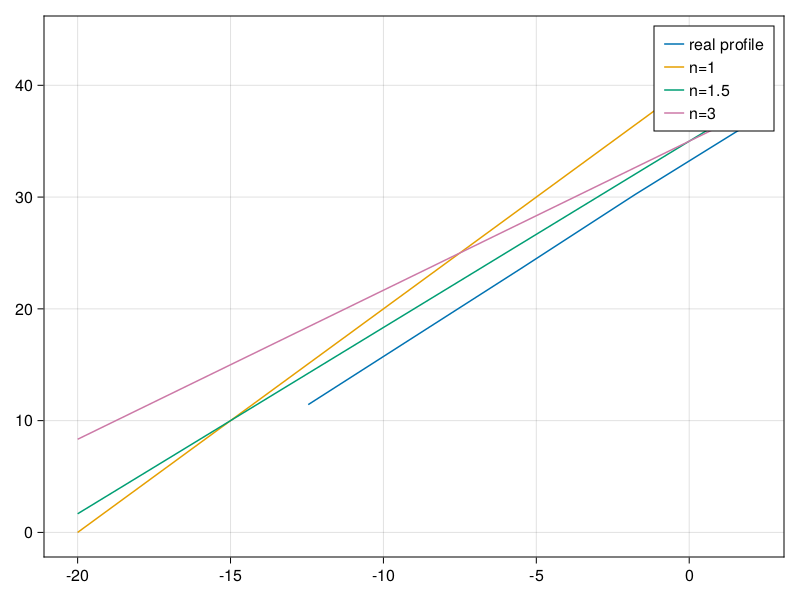

In [8]:
ρprofile = zeros(sm.nz)
for i in 1:sm.nz
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]], sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]], [1.0], [:H1])
    ρprofile[i] = eos_result[1]
end

using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, log.(ρprofile), [sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] for i in 1:sm.nz], label="real profile")
xvals = LinRange(-20,2,100)
lines!(ax,xvals,(1+1/1) .* xvals .+ 40, label="n=1")
lines!(ax,xvals,(1+1/(1.5)) .* xvals .+ 35, label="n=1.5")
lines!(ax,xvals,(1+1/3) .* xvals .+ 35, label="n=3")
axislegend(ax)
f

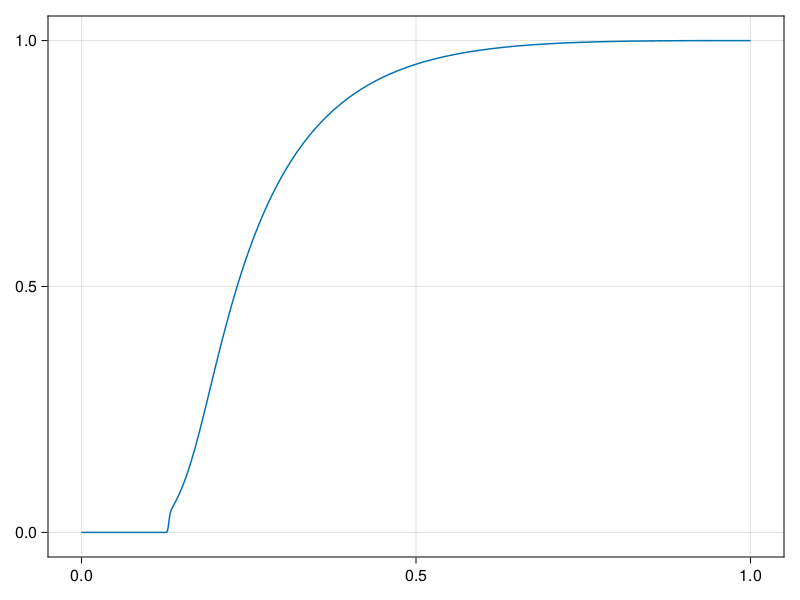

In [15]:
using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, m_face/MSUN, ([sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] for i in 1:sm.nz]))
f

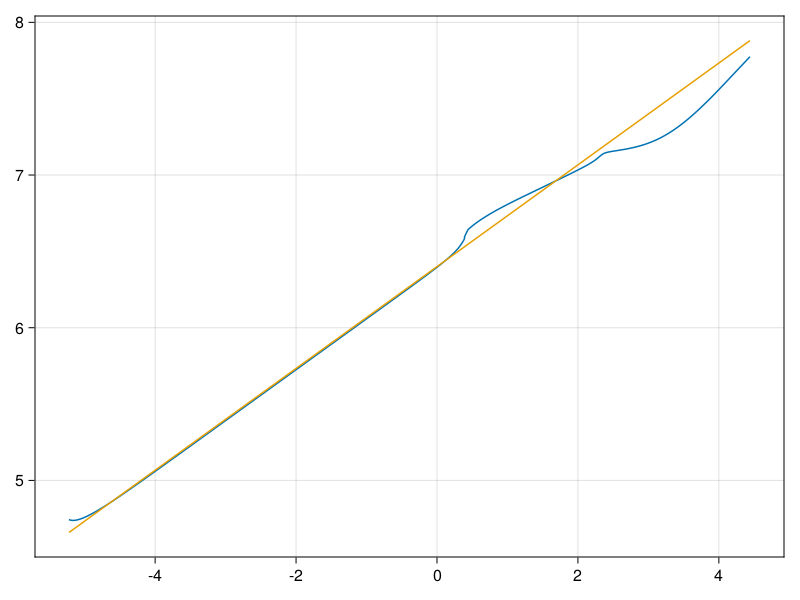

In [16]:
ρcenter = zeros(nsteps)
for i in 1:nsteps
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
        log(Tcenter[i]), log(Pcenter[i]), [1.0], [:H1])
    ρcenter[i] = eos_result[1]
end

using CairoMakie
using LaTeXStrings

f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, log10.(ρcenter), log10.(Tcenter))
lines!(ax, log10.(ρcenter), log10.(ρcenter)./3 .+ 6.4)
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

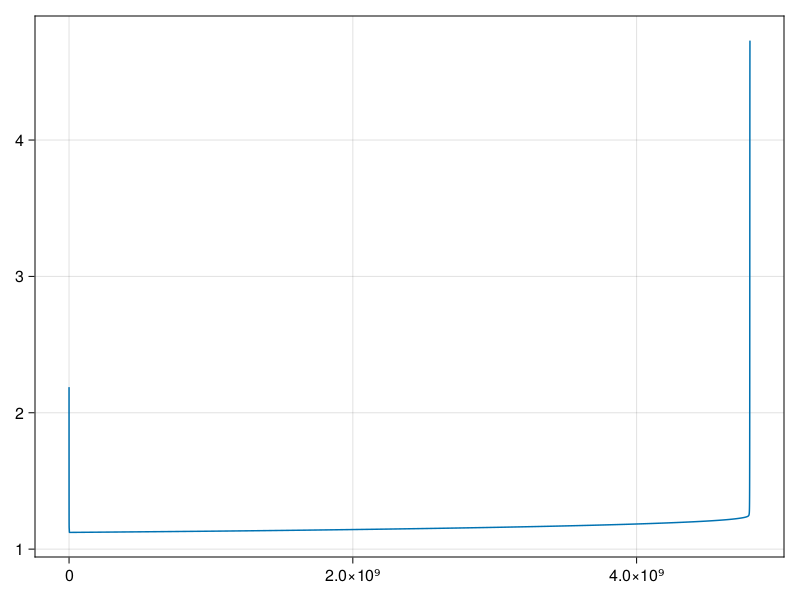

In [17]:
f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, times, log10.(Rsurf/RSUN)) # not contracting right now?
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

In [18]:
using HDF5

ArgumentError: ArgumentError: Package HDF5 not found in current path.
- Run `import Pkg; Pkg.add("HDF5")` to install the HDF5 package.

In [21]:
using HDF5
fid = h5open("example_output.hdf5", "w")

🗂️ HDF5.File: (read-write) example_output.hdf5

In [22]:
fid["zero_matrix"] = zeros(0, 0)

0×0 Matrix{Float64}

In [23]:
typeof(fid["zero_matrix"])

HDF5.Dataset

In [25]:
fid["matrix"] = ones(3, 5)

3×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [29]:
fid["matrix"][1:end,1:end]

3×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [30]:
using HDF5

# Open the HDF5 file in "r+" mode to enable read and write operations
fid = h5open("example_output.hdf5", "r+")

# Read the current dataset into a variable
current_matrix = read(fid["matrix"])

# Create a new row (in this example, we are adding a row of ones)
new_row = ones(1, size(current_matrix, 2))

# Resize the dataset to accommodate the new row
new_rows_count = size(current_matrix, 1) + size(new_row, 1)
setsize(fid["matrix"], (new_rows_count, size(current_matrix, 2)))

# Assign the new row to the dataset
current_matrix[end + 1, :] = new_row

# Write the updated matrix back to the dataset
write(fid["matrix"], current_matrix)

# Close the HDF5 file
close(fid)

UndefVarError: UndefVarError: `setsize` not defined

In [31]:
using HDF5

# Open the HDF5 file in "r+" mode to enable read and write operations
fid = h5open("example_output.hdf5", "r+")

# Read the current dataset into a variable
current_matrix = read(fid["matrix"])

# Create a new row (in this example, we are adding a row of ones)
new_row = ones(1, size(current_matrix, 2))

# Extend the dataset with the new row using ChunkedArray
extend(fid["matrix"], size(current_matrix, 1) + 1, size(current_matrix, 2))

# Append the new row to the dataset
write(fid["matrix"], new_row, size(current_matrix, 1) + 1)

# Close the HDF5 file
close(fid)

UndefVarError: UndefVarError: `extend` not defined

In [70]:
using Printf

x = 1
significant_digits = 6
padding_spaces = 15

format_string = "%$(padding_spaces).$(significant_digits)e"
formatted_string = Printf.format(Printf.Format(format_string), x)
println(formatted_string)
println(length(formatted_string))

   1.000000e+00
15


In [49]:
@sprintf "%15.1f" 34.567

"           34.6"

In [54]:
@sprintf "%10.6f" x

"123.456789"

In [71]:
data = """
           [database]
           server = "192.168.1.1"
           ports = [ 8001,
                     8001,
                     8002 ]
       """;

In [72]:
using TOML

In [77]:
TOML.parse(data)["database"]

Dict{String, Any} with 2 entries:
  "server" => "192.168.1.1"
  "ports"  => [8001, 8001, 8002]

In [78]:
a=:asd
@show "$a"

"$(a)" = "asd"


"asd"